## Imports

In [7]:
import glob
import cv2
import json
import time
import numpy as np
from PIL import ImageColor
from numba import jit
from os.path import exists

import scipy.io as sio
from scipy import io

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

#### Create masks from annotations and create mat files

- Read images
- Read annotation for each image
- Create mask for annotation
- Create mat file from annotation

In [4]:
# define some variables
image_path = './images/' # path to image folder
annotation_path = './annotation/json/' # path to where the json annotations should be
annotation_path_mat = './annotation/mat/' # path to where the masks are stored in .mat files

# list of files in directory
image_list = glob.glob(image_path + '*.*') # get a list of image urls


# define some static annotation paths and open them
file_goal = open(f"./static_annotations/Goal.json") # Goal
file_doellijn = open(f"./static_annotations/Doellijn.json") # Doellijn

data_goal = json.load(file_goal)  # Read goal file and convert from json to dict
data_doellijn = json.load(file_doellijn)

# define colors for mask
color_doellijn = (255,0,0)
color_goal = (0,255,0)
color_bal = (0,0,255)
color_background = (240,0,240)

labels_static = [{'label': 'Doellijn', 'color': color_doellijn, 'annotations': data_doellijn},{'label': 'Goal', 'color': color_goal, 'annotations': data_goal}]
labels_dynamic = [{'label': 'Bal', 'color': color_bal}]


In [8]:
image_annotations = []

for image in image_list:
    image_name = image.split('\\')[1].split('.')[0]
    if exists(annotation_path + f"{image_name}.json"):
        img = cv2.imread(image)

        f = open(annotation_path + f"{image_name}.json")
        data = json.load(f)

        obj = {
            'image_name': image_name,
            'image': img,
            'annotations': data
        }

        image_annotations.append(obj)


In [9]:
def get_color(labelname):
    return [lc['color'] for lc in labels_dynamic if lc['label'] == labelname]

#### Show single image mask

In [9]:
# ia = image_annotations[10]
# image_name = ia['image_name']
# image = ia['image']
# annotations = ia['annotations']['annotations']

# start_time = time.time()
# img = np.zeros((1080, 1920, 3), dtype = "uint8")
# img[:] = color_background

# img_new = None
# for annotation in annotations:

#     for ann in annotation:

#         if 'polygonlabels' in ann['value']:
#             lb = ann['value']['polygonlabels'][0]
#             sl = [label['label'] for label in labels_static]
#             if lb not in labels_static:
#                 # draw the polygon
#                 points = [[point[0] / 100 * ann['original_width'], point[1] / 100 * ann['original_height']] for point in ann['value']['points']]
#                 try:
#                     h = get_color(lb)[0]
#                     pts = np.array(points, np.int32)
#                     img_new = cv2.fillPoly(img, [pts], h)

#                 except:
#                     pass

# for static in labels_static:
#     points = [[point[0] / 100 * ann['original_width'], point[1] / 100 * ann['original_height']] for point in static['annotations']['value']['points']]


#     pts = np.array(points, np.int32)
#     img_new = cv2.fillPoly(img, [pts], static['color'])
# cv2.imshow('Mask', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [10]:
# apply to all images and add to list
masks = []
for ia in image_annotations: 
    image_name = ia['image_name']
    image = ia['image']
    annotations = ia['annotations']['annotations']

    start_time = time.time()
    img = np.zeros((1080, 1920, 3), dtype = "uint8")
    img[:] = color_background
    
    img_new = None
    for annotation in annotations:

        for ann in annotation:

            if 'polygonlabels' in ann['value']:
                lb = ann['value']['polygonlabels'][0]
                sl = [label['label'] for label in labels_static]
                if lb not in labels_static:
                    # draw the polygon
                    points = [[point[0] / 100 * ann['original_width'], point[1] / 100 * ann['original_height']] for point in ann['value']['points']]
                    try:
                        h = get_color(lb)[0]
                        pts = np.array(points, np.int32)
                        img_new = cv2.fillPoly(img, [pts], h)

                    except:
                        pass

    # for static in static_labels:
    #     points = [[point[0] / 100 * ann['original_width'], point[1] / 100 * ann['original_height']] for point in static['annotations']['value']['points']]


    #     pts = np.array(points, np.int32)
    #     img_new = cv2.fillPoly(img, [pts], static['color'])
    
    masks.append((image_name,img))

In [11]:
@jit
def loop_row(row):
    pixel_color = (row[0], row[1], row[2])
    if pixel_color == color_bal:
        return 1
    elif pixel_color == color_doellijn:
        return 2
    elif pixel_color == color_goal:
        return 3
    else:
        return 0


@jit # precompile to make function
def image_to_pixel_class(image):
    new_col = []
    for col in image:
        new_row = []
        for row in col:
            new_row.append(loop_row(row))
        new_col.append(new_row)
    return new_col

In [12]:
# set url to where mat files should be stored
url_mat = './annotation/mat/'

In [13]:
start_time = time.time()
for mask in masks:
    image_class_pixel = image_to_pixel_class(mask[1])
    sio.savemat(url_mat + mask[0] + '.mat', {'groundtruth':image_class_pixel}, oned_as='column')
print(f"time: {time.time() - start_time} s")

time: 19.325387716293335 s


#### Read image and annotation files

In [50]:
images = []
for ia in image_annotations:
    img = cv2.cvtColor(ia['image'], cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img))

In [51]:
masks = []
for m in glob.glob('./annotation/mat/*.mat'):
    file = io.loadmat(m)
    mask = tf.convert_to_tensor(file['groundtruth'])
    masks.append(mask)

In [52]:
len(images), len(masks)

(104, 104)

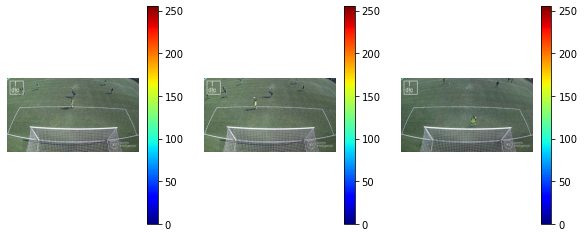

In [53]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

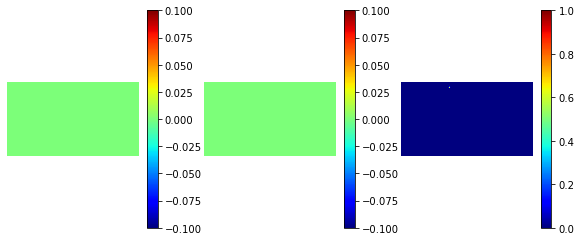

In [54]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show()

In [55]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 0)

#### Create deep learning model

In [56]:
base = keras.applications.DenseNet121(input_shape=[1280,720,3], include_top=False, weights='imagenet')

In [58]:
len(base.layers)

427

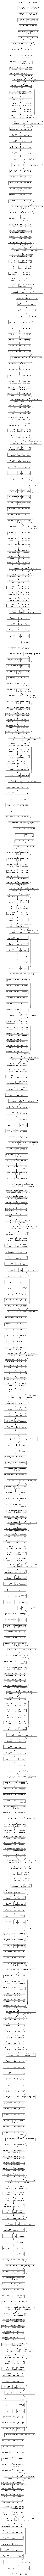

In [59]:
keras.utils.plot_model(base, show_shapes=True)

In [60]:
skip_names = ['conv1/relu', # size 64*64
              'pool2_relu',  # size 32*32
              'pool3_relu',  # size 16*16
              'pool4_relu',  # size 8*8
              'relu'        # size 4*4
              ] 
              
skip_outputs = [base.get_layer(name).output for name in skip_names]
for i in range(len(skip_outputs)):
    print(skip_outputs[i])

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv1/relu/Relu:0', description="created by layer 'conv1/relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='pool2_relu/Relu:0', description="created by layer 'pool2_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 512), dtype=tf.float32, name=None), name='pool3_relu/Relu:0', description="created by layer 'pool3_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1024), dtype=tf.float32, name=None), name='pool4_relu/Relu:0', description="created by layer 'pool4_relu'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [61]:
downstack = keras.Model(inputs=base.input,
                        outputs=skip_outputs)
downstack.trainable = False

In [62]:
from tensorflow_examples.models.pix2pix import pix2pix
 # Four upstack blocks for upsampling sizes 
 # 4->8, 8->16, 16->32, 32->64 
upstack = [pix2pix.upsample(512,3),
        pix2pix.upsample(256,3),
        pix2pix.upsample(128,3),
        pix2pix.upsample(64,3)] 
upstack[0].layers

In [63]:
# define the input layer
inputs = keras.layers.Input(shape=[1280,720,3])
# downsample 
down = downstack(inputs)
out = down[-1]
# prepare skip-connections
skips = reversed(down[:-1])
# choose the last layer at first 4 --> 8
# upsample with skip-connections
for up, skip in zip(upstack,skips):
    out = up(out)
    out = keras.layers.Concatenate()([out,skip])
# define the final transpose conv layer
# image 128 by 128 with 59 classes
out = keras.layers.Conv2DTranspose(59, 3,
                                strides=2,
                                padding='same',
                                )(out)
# complete unet model
unet = keras.Model(inputs=inputs, outputs=out)

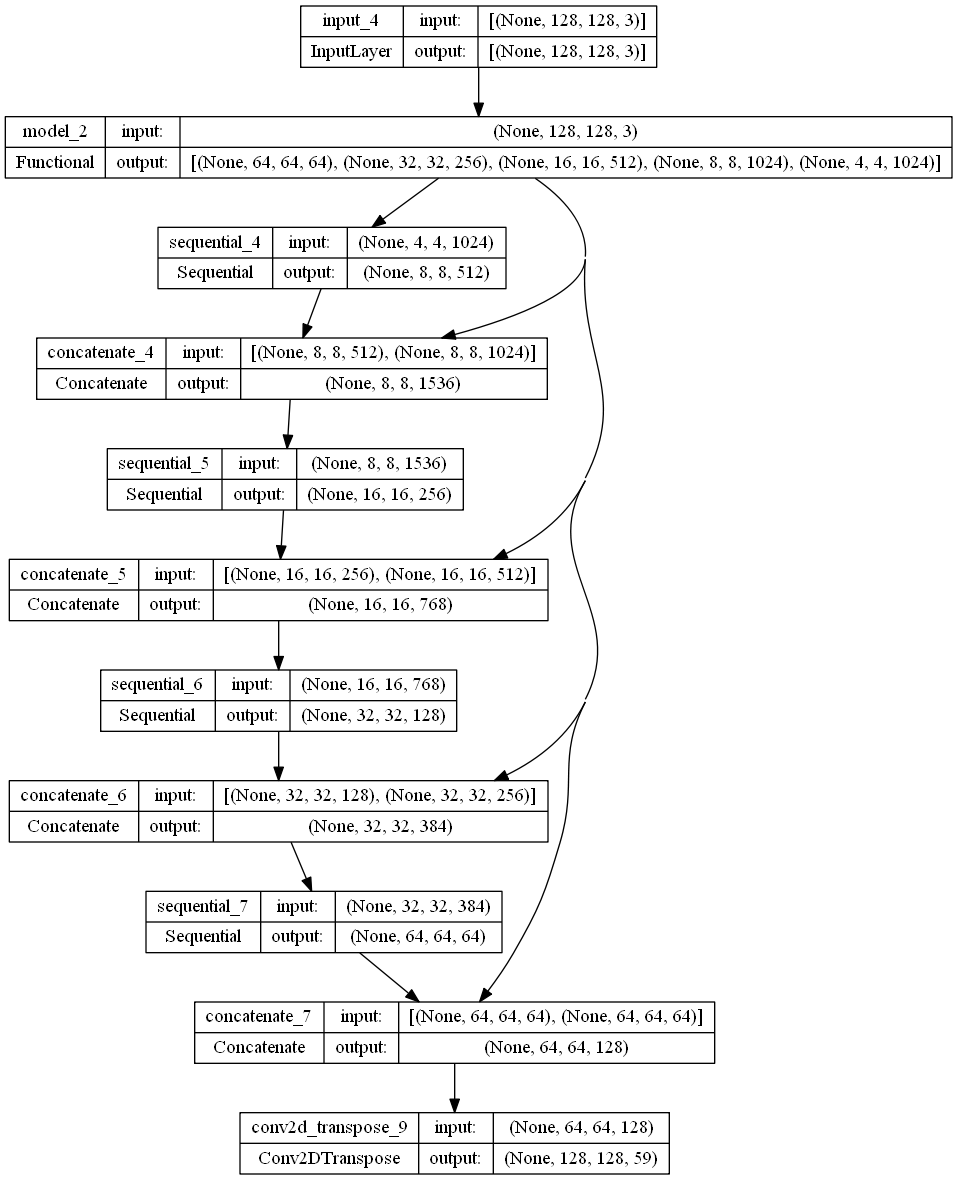

In [64]:
keras.utils.plot_model(unet, show_shapes=True)

In [65]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    # scale values to [0,1]
    image = image / 255.0
    # resize image
    image = tf.image.resize(image, (1280,720))
    return image

def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (1280,720))
    mask = tf.cast(mask, tf.uint8)
    return mask

In [66]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]

In [67]:
from sklearn.model_selection import train_test_split
train_X, val_X,train_y, val_y = train_test_split(X,y, 
                                                    test_size=0.2, 
                                                    random_state=0
                                                    )
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)
train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(1280, 720, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(1280, 720, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(1280, 720, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(1280, 720, 1), dtype=tf.uint8, name=None))

In [68]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

In [69]:
def brightness(img, mask):
     img = tf.image.adjust_brightness(img, 0.1)
     return img, mask
 
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (1280,720))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (1280,720))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask 

In [70]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

In [71]:
# perform augmentation on train data only
a = train.map(brightness)
b = train.map(gamma)
c = train.map(hue)
d = train.map(crop)
e = train.map(flip_hori)
f = train.map(flip_vert)
g = train.map(rotate)

train = train.concatenate(a)
train = train.concatenate(b)
train = train.concatenate(c)
train = train.concatenate(d)
train = train.concatenate(e)
train = train.concatenate(f)
train = train.concatenate(g)

In [72]:
BATCH = 64
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
train = train.prefetch(buffer_size=AT)
val = val.batch(BATCH)

In [73]:
example = next(iter(train))
preds = unet(example[0])
plt.imshow(example[0][60])
plt.colorbar()
plt.show()

InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [1280,720,3] and element 21 had shape [720,1280,3]. [Op:IteratorGetNext]

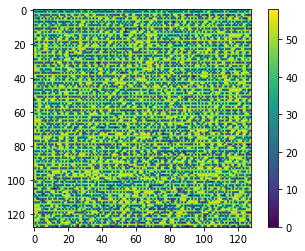

In [38]:
pred_mask = tf.argmax(preds, axis=-1)
pred_mask = tf.expand_dims(pred_mask, -1)
plt.imshow(pred_mask[0])
plt.colorbar()

In [49]:
unet.compile(loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
             metrics=['accuracy']) 

hist = unet.fit(train,
                validation_data=val,
                steps_per_epoch=STEPS_PER_EPOCH,
                validation_steps=VALIDATION_STEPS,
                epochs=50) 

Epoch 1/50
12/12 [==============================] - 39s 3s/step - loss: 0.5217 - accuracy: 0.9611 - val_loss: 0.0580 - val_accuracy: 1.0000
Epoch 2/50
12/12 [==============================] - 37s 3s/step - loss: 0.0038 - accuracy: 0.9999
Epoch 3/50
12/12 [==============================] - 38s 3s/step - loss: 0.0034 - accuracy: 0.9999
Epoch 4/50
12/12 [==============================] - 38s 3s/step - loss: 0.0033 - accuracy: 0.9999
Epoch 5/50
12/12 [==============================] - 37s 3s/step - loss: 0.0030 - accuracy: 0.9999
Epoch 6/50
12/12 [==============================] - 38s 3s/step - loss: 0.0021 - accuracy: 0.9999
Epoch 7/50
12/12 [==============================] - 38s 3s/step - loss: 0.0015 - accuracy: 0.9999
Epoch 8/50
 9/12 [=====================>........] - ETA: 9s - loss: 9.5829e-04 - accuracy: 0.9999 

KeyboardInterrupt: 

1/1 [==============================] - 1s 759ms/step


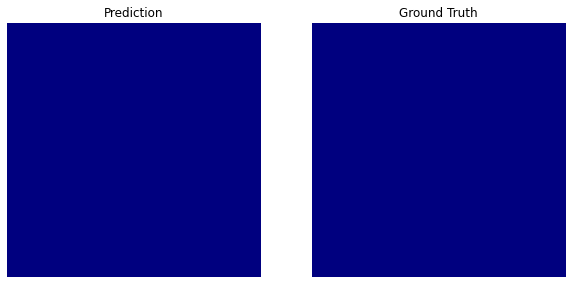

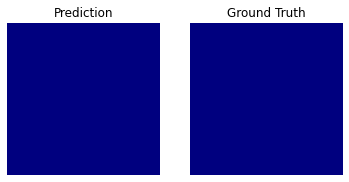

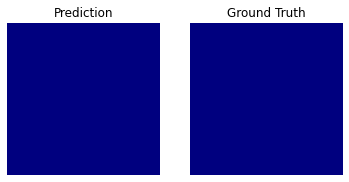

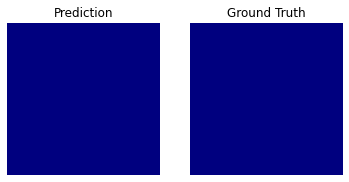

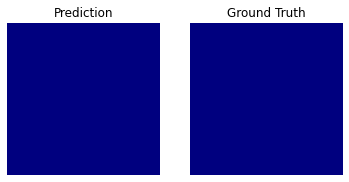

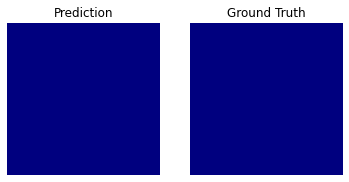

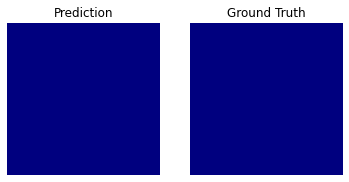

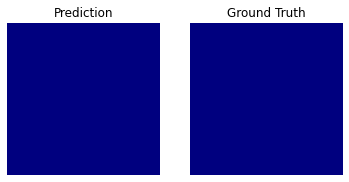

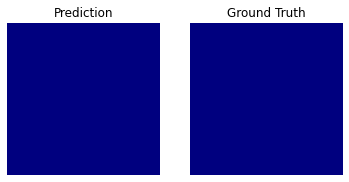

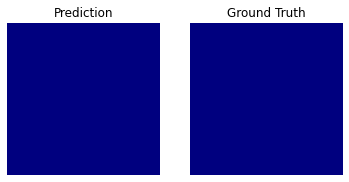

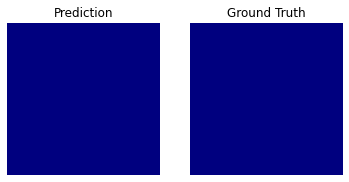

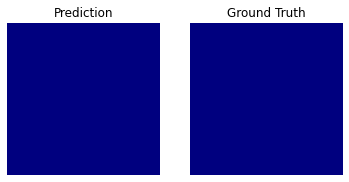

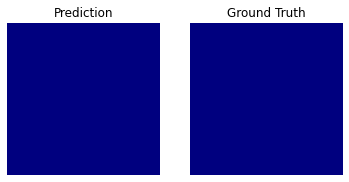

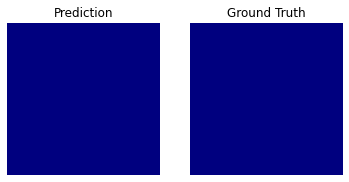

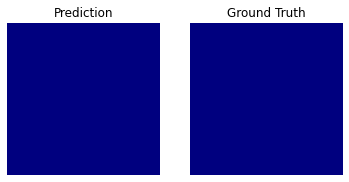

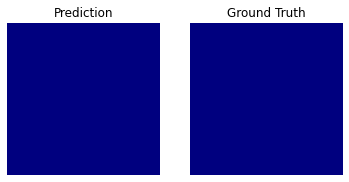

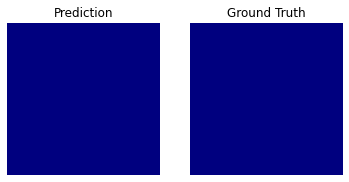

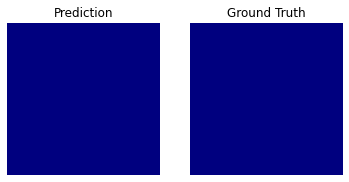

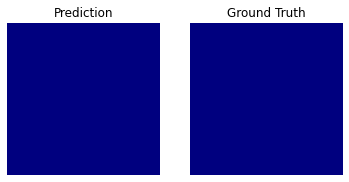

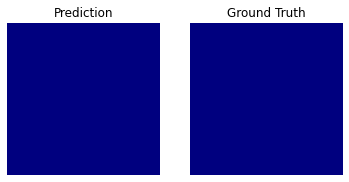

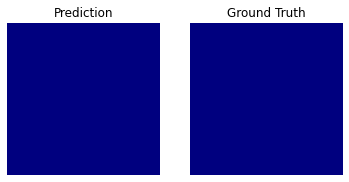

In [48]:
iter_val = iter(val)

img, mask = next(iter_val)

pred = unet.predict(img)
plt.figure(figsize=(10,5))
for i in pred:
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')

    plt.subplot(122)
    plt.imshow(mask[0], cmap='jet')
    plt.axis('off')
    plt.title('Ground Truth')
    plt.show()

[0.9999680519104004]


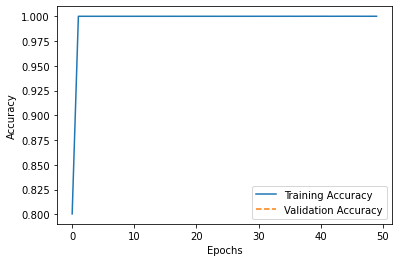

In [41]:
history = hist.history
print(history['val_accuracy'])
acc = history['accuracy']
val_acc = history['val_accuracy']
plt.plot(acc, '-', label='Training Accuracy')
plt.plot(val_acc, '--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()